In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as sts

import os
import pickle

import SAM
import float_data as flt

import importlib
importlib.reload(SAM)
importlib.reload(flt)

from dask import delayed

In [3]:
model_folder = 'model'
n_classes = 7
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)
data_classes = {}
path_ref = '{}/{}/{}'.format(model_folder, ids[0], n_classes)
with open('{}/avg.obj'.format(path_ref), 'rb') as file:
    ref_profiles = pickle.load(file)
    file.close()


    
for (m_i, m_id) in enumerate(ids):
  
    print('Starting {}'.format(m_id))
    path_id = '{}/{}'.format(model_folder, m_id)
    path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)
    path_data = 'data/{}/{}'.format(m_id, n_classes)

    with open('{}/pca.obj'.format(path_id), 'rb') as file:
        pca = pickle.load(file)
        file.close()

    with open('{}/gmm.obj'.format(path_n), 'rb') as file:
        gmm = pickle.load(file)
        file.close()

    with open('{}/avg.obj'.format(path_data), 'rb') as file:
        avg_profiles = pickle.load(file)
        file.close()

    options = {'memberId' : m_id, 'raw' : True}
    data = flt.retrieve_profiles(timeRange = slice('1975-01', '1979-12'), mask=mask, options=options)
    data = data.chunk({'time': data.sizes['time'], 'i' : 64, 'j':64})
    data_sampled = flt.normalise_data(data, ('i', 'j', 'time'))
    data_trans = flt.pca_transform(data_sampled, pca)
    
    data_c = flt.gmm_classify(data_trans, gmm).compute()
    data_classes[m_id] = data_c
    continue
    lats = data_c['lat'].values
    lons = data_c['lon'].values
    lev = data['lev'].values
    times = data['time'].values
    alpha = np.logical_not(data.isel(time=0, lev=-1).isnull().values)
    

    plt_data = data_c.values

    #plt_data[plt_data == -1] = 0
    for yr in range(np.size(plt_data, 0)):
        fig = plt.figure()
        
        ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())
        ax.pcolormesh(lons, lats, plt_data[yr, :, :], transform=ccrs.PlateCarree(), alpha=alpha, cmap='YlOrRd') #, cmap='YlOrRd'
        ax.coastlines()
        ax.set_title('{}, {}'.format(m_id, times[yr].astype('datetime64[M]')))
        ax.set_facecolor((0.7, 0.7, 0.7, 1))
        
    
        fig.set_size_inches(7, 7)
        #plt.savefig('figures/anim_mm/{:03d}'.format(yr), dpi=300, bbox_inches='tight')
        
        print(yr)
        plt.show()
        plt.close(fig)
    
    
print('Done!')

Starting r1i1p1f2
Starting r2i1p1f2
Starting r3i1p1f2
Starting r4i1p1f2
Starting r5i1p1f3
Starting r6i1p1f3
Starting r7i1p1f3
Starting r8i1p1f2
Starting r9i1p1f2
Starting r10i1p1f2
Done!
Starting r1i1p1f2
Starting r2i1p1f2
Starting r3i1p1f2
Starting r4i1p1f2
Starting r5i1p1f3
Starting r6i1p1f3
Starting r7i1p1f3
Starting r8i1p1f2
Starting r9i1p1f2
Starting r10i1p1f2
Done!


In [8]:
avg_profiles = {}
for m_id in ids:
    
    print('Starting {}'.format(m_id))
    path_id = 'model/{}'.format(m_id)
    path_n = 'model/{}/{}'.format(m_id, n_classes)
    path_data = 'data/{}/{}'.format(m_id, n_classes)
    

    if os.path.exists('{}/avg.obj'.format(path_data)):
        with open('{}/avg.obj'.format(path_data), 'rb') as file:
            avg_profiles[m_id] = pickle.load(file)
            file.close()
print('Done!')

Starting r1i1p1f2
Starting r2i1p1f2
Starting r3i1p1f2
Starting r4i1p1f2
Starting r5i1p1f3
Starting r6i1p1f3
Starting r7i1p1f3
Starting r8i1p1f2
Starting r9i1p1f2
Starting r10i1p1f2
Done!


0


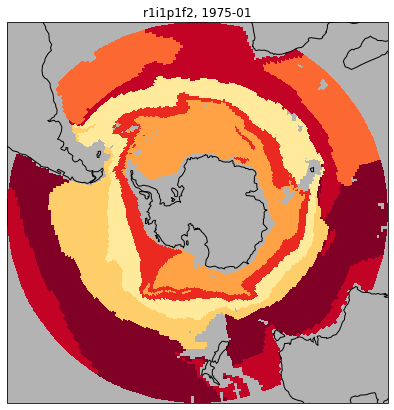

0


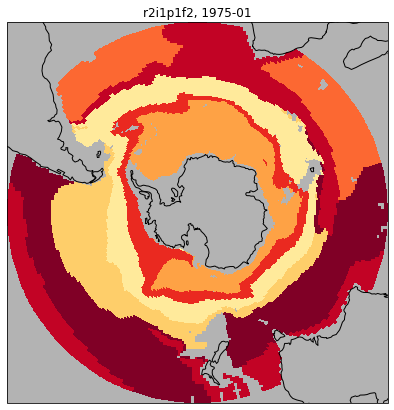

0


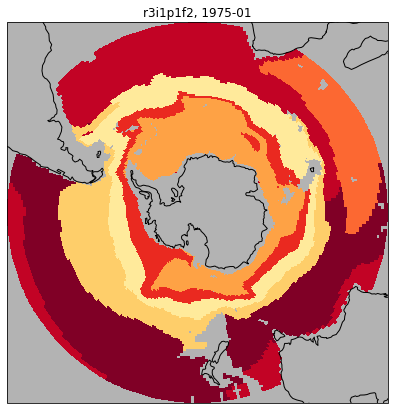

In [ ]:
for (m_i, m_id) in enumerate(ids):
  data_c = data_classes[m_id]
  if m_i == 0:
    inds = flt.temp_sort(None, ref_profiles, True)
  else:
    inds = flt.match_spatial(data_c, data_classes[ids[0]], n_classes)
    
  data_classes[m_id] = flt.reorder(data_classes[m_id], inds).compute()
  avg_profiles[m_id] = [avg_profiles[m_id][x] for x in inds]
  data_c = data_classes[m_id]
  
  lats = data_c['lat'].values
  lons = data_c['lon'].values
  lev = data['lev'].values
  times = data['time'].values
  alpha = np.logical_not(data.isel(time=0, lev=-1).isnull().values)

  plt_data = data_c.values

  #plt_data[plt_data == -1] = 0
  for yr in range(np.size(plt_data, 0)):
    fig = plt.figure()

    ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())
    ax.pcolormesh(lons, lats, plt_data[yr, :, :], transform=ccrs.PlateCarree(), alpha=alpha, cmap='YlOrRd') #, cmap='YlOrRd'
    ax.coastlines()
    ax.set_title('{}, {}'.format(m_id, times[yr].astype('datetime64[M]')))
    ax.set_facecolor((0.7, 0.7, 0.7, 1))


    fig.set_size_inches(7, 7)
    #plt.savefig('figures/anim_mm/{:03d}'.format(yr), dpi=300, bbox_inches='tight')

    print(yr)
    plt.show()
    plt.close(fig)
    break

In [9]:
avg_profiles

{'r1i1p1f2': [{'mean': array([-0.3780851 , -0.09128501,  0.16091618,  0.3625429 ,  0.5156036 ,
           0.63114315,  0.7239415 ,  0.79816145,  0.8606734 ,  0.90948886,
           0.94834507,  0.97434133,  0.9879745 ,  0.98853844,  0.9769699 ,
           0.9537444 ,  0.91939116,  0.8750111 ,  0.8216086 ,  0.761462  ,
           0.69606054,  0.6266599 ,  0.5552516 ,  0.48345962,  0.4136208 ,
           0.3466451 ,  0.28384322,  0.22523263,  0.1716053 ,  0.12327543],
         dtype=float32),
   'std': array([0.8869963 , 0.88811046, 0.890734  , 0.89502996, 0.8966019 ,
          0.8898393 , 0.87438434, 0.8510597 , 0.8226112 , 0.78859836,
          0.7518987 , 0.71277976, 0.67212415, 0.630486  , 0.58868974,
          0.5486063 , 0.51164263, 0.47830313, 0.44793007, 0.42013314,
          0.3943327 , 0.36952776, 0.34546956, 0.32162383, 0.29883483,
          0.277431  , 0.25774276, 0.23947917, 0.22380565, 0.21073614],
         dtype=float32)},
  {'mean': array([6.932176 , 6.8276224, 6.732335 ,

In [ ]:
indices = np.array([flt.match_spatial(data_classes[ids[0]], data_classes[x], n_classes) for x in ids])

In [ ]:
indices_avg = np.array([flt.match_profiles(avg_profiles[ids[0]], avg_profiles[x]) for x in ids])

In [ ]:

for (a, b, i) in zip(indices, indices_avg, ids):
  print(i)
  print("  Bijective spatial plots: {}".format(len(a) == len(np.unique(a))))
  print("  Bijective profiles: {}".format(len(b) == len(np.unique(b))))
  print("  Same assignment? {}".format(np.all(a == b)))

In [ ]:
indices